In [6]:
import subprocess 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
import itertools
import random

## Generación de prueba

In [7]:
input_path = "../datos_entrada/ej2/"

In [8]:
def combinacionValida(n,ejes):
    for i in range(n,1,-1):
        if len([(x,y) for x,y in ejes if y == i or x == i]) == 0:
            return False
    return True
        

In [9]:
repeticiones=10
tamanios=range(2,11)
files = []
for n in tamanios:
    ejes_posibles = list(itertools.combinations(range(1,n+1),2))
    
    m = random.randint(1,len(ejes_posibles))
    
    random.shuffle(ejes_posibles)
    while not combinacionValida(n,ejes_posibles[0:m]):
        m = m + 1
    ejes = ejes_posibles[0:m]
    
    file = f"exp_random_{n}nodos_{m}ejes.txt"
    
    f = open(f"{input_path}/{file}", "w")
    f.write(f"{n} {m}\n")
    for i in range(0,n):
        costo = random.randint(1,100)
        f.write(f"{costo}\n")
    for (src,dest) in ejes:
        distancia = random.randint(1,100)
        f.write(f"{src} {dest} {distancia}\n")
    f.close()
    
    files.append(os.path.abspath(f"{input_path}/{file}"))

In [14]:
resultFile = f"{input_path}/results.csv"
f = open(resultFile,"a+")
for file in files:
    completado = subprocess.run(["../../Resolucion/bin/ej2",file,str(4)], stdout=subprocess.PIPE, universal_newlines=True)
    f.write(completado.stdout)
    if completado.returncode != 0:
        print("ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo))
f.close()    

In [15]:
csv = pandas.read_csv(resultFile)


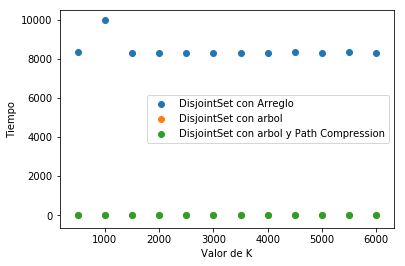

In [5]:
plt.clf()
for method in csv["Metodo"].unique():
    csvOnlyNames = csv.dropna(subset=['Filename'])
    methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
    resultsByK = [np.median(methodResults[methodResults["k"] == k]["Tiempo"]) for k in kRange]
    plt.scatter(kRange,resultsByK,label=method)


plt.legend();
plt.xlabel("Valor de K")
plt.ylabel("Tiempo");


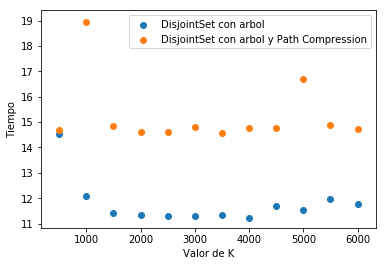

In [6]:
plt.clf()
for method in csv["Metodo"].unique():
    if method != "DisjointSet con Arreglo":
        csvOnlyNames = csv.dropna(subset=['Filename'])
        methodResults = csvOnlyNames[csvOnlyNames["Metodo"]==method]
        resultsByK = [np.median(methodResults[methodResults["k"] == k]["Tiempo"]) for k in kRange]
        plt.scatter(kRange,resultsByK,label=method)


plt.legend();
plt.xlabel("Valor de K")
plt.ylabel("Tiempo");


### Corelación entre tiempo de ejecución y cota de algortimo para cada una de estructuras

In [10]:
#casos de interes son los que tiene nombre y un k que pertenezca al rango [500,6000]
csv_cotas = pandas.DataFrame()
for k in kRange:
    csv_aux_name = csv.dropna(subset=['Filename'])
    csv_aux_k = csv_aux_name[csv_aux_name["k"] == k]
    csv_cotas = pandas.concat([csv_cotas, csv_aux_k])
#todos los nombres tienen el mismo formato "nombre_num_anchoxalto.extension"
csv_cotas.loc[csv_cotas['Filename'] == 'test1.jpg', 'Filename'] = 'test_1_320x240.jpg'
csv_cotas.loc[csv_cotas['Filename'] == 'test2.png', 'Filename'] = 'test_2_320x240.png'
#armar columna n, donde n es la cant de pixeles cada imagen
split_guion_csv = pandas.DataFrame()
split_guion_csv[['nombre', 'num', 'anchoxalto']] = csv_cotas['Filename'].str.split('_', expand=True)
split_x_csv = pandas.DataFrame()
split_x_csv[['ancho', 'alto']] = split_guion_csv['anchoxalto'].str.split('x', expand=True)
split_x_csv['ancho'] = pandas.to_numeric(split_x_csv['ancho'])
split_x_csv['alto'] = split_x_csv['alto'].str.rstrip('.png')
split_x_csv['alto'] = split_x_csv['alto'].str.rstrip('.jpg')
split_x_csv['alto'] = pandas.to_numeric(split_x_csv['alto'])
csv_cotas["n"] = split_x_csv['ancho'] * split_x_csv['alto']
#separo por metodos y por cada uno armo la columna cota 
csv_cotas_arr = csv_cotas[csv_cotas['Metodo'] == 'DisjointSet con Arreglo']
csv_cotas_arb = csv_cotas[csv_cotas['Metodo'] == 'DisjointSet con arbol']
csv_cotas_arbYpath = csv_cotas[csv_cotas['Metodo'] == 'DisjointSet con arbol y Path Compression']
csv_cotas_arr.loc[:,"cota"] = csv_cotas_arr["n"] * csv_cotas_arr["n"]
csv_cotas_arb.loc[:,"cota"] = csv_cotas_arb["n"] * np.log(csv_cotas_arb["n"])
csv_cotas_arbYpath.loc[:,"cota"] = csv_cotas_arbYpath["n"] * np.log(csv_cotas_arbYpath["n"])

<Figure size 432x288 with 0 Axes>

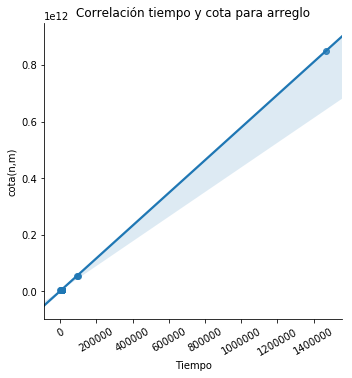

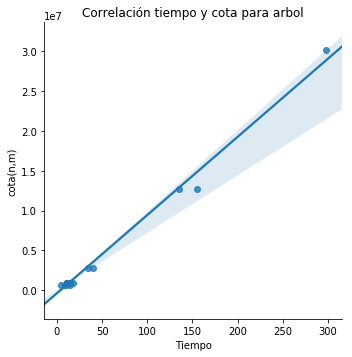

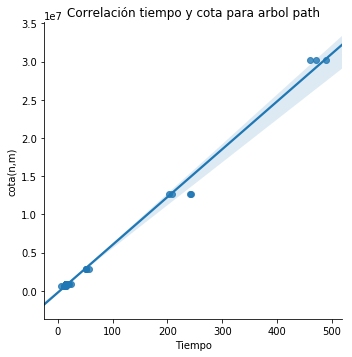

In [13]:
plt.clf()
# # Grafico correlación.
ax1 = sns.lmplot(x='Tiempo', y='cota', data=csv_cotas_arr);
ax1.set_xticklabels(rotation=30)
plt.title('Correlación tiempo y cota para arreglo')
plt.xlabel("Tiempo");
plt.ylabel("cota(n,m)");

ax2 = sns.lmplot(x='Tiempo', y='cota', data=csv_cotas_arb);
plt.title('Correlación tiempo y cota para arbol')
plt.xlabel("Tiempo");
plt.ylabel("cota(n,m)");

ax3 = sns.lmplot(x='Tiempo', y='cota', data=csv_cotas_arbYpath);
plt.title('Correlación tiempo y cota para arbol path')
plt.xlabel("Tiempo");
plt.ylabel("cota(n,m)");

fig = plt.gcf()

In [14]:
c_arr = np.corrcoef(csv_cotas_arr["Tiempo"], csv_cotas_arr["cota"])[0, 1];
print("El coeficiente de correlación de Pearson para arreglo es: c_arr="+str(c_arr))
c_arb = np.corrcoef(csv_cotas_arb["Tiempo"], csv_cotas_arb["cota"])[0, 1];
print("El coeficiente de correlación de Pearson para arbol es: c_arb="+str(c_arb))
c_arbYpath = np.corrcoef(csv_cotas_arbYpath["Tiempo"], csv_cotas_arbYpath["cota"])[0, 1];
print("El coeficiente de correlación de Pearson para arbol con path compresion es: arbYpath="+str(c_arbYpath))

El coeficiente de correlación de Pearson para arreglo es: c_arr=0.9999770949254846
El coeficiente de correlación de Pearson para arbol es: c_arb=0.9959731253985665
El coeficiente de correlación de Pearson para arbol con path compresion es: arbYpath=0.997257771055391


## Experimento 2: Tiempo de ejecución según tamaño de la imagen

### Considerando DisjointSet con Arreglo

In [3]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        #"sintetico_1_640x360.png": None,
        #"sintetico_1_1280x720.png": None,
        #"sintetico_1_1920x1080.png": None,
}
methods = [0,1,2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [4]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print("ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={0} metodo={1}".format(k,metodo))

In [5]:
csv = pandas.read_csv(csvFileName)

DisjointSet con Arreglo [5364.725]
DisjointSet con arbol [9.63416]
DisjointSet con arbol y Path Compression [11.973849999999999]


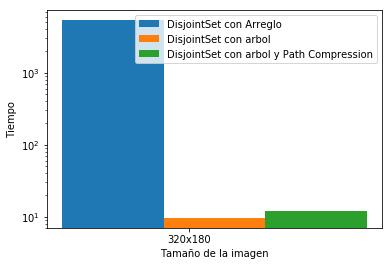

In [7]:
plt.clf()

metodos = csv["Metodo"].unique()
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180"][:len(images.keys())])
plt.yscale('log')

Incluso en el caso de la imagen más chica(320x180) el metodo con DisjointSet con Arreglo tarda varios ordenes de magnitud más que los otros dos casos, por lo que de ahora en adelante vamos a descartarlo por ser demasiado lento.

### Sin considerar DisjointSet con Arreglo

In [25]:
image_path = "../datos_entrada/ej1/"
csvFileName="./ej1_tiempos.csv"
testCases="testCases.in"
test_times = 10
images = {
        "sintetico_1_320x180.png": None,
        "sintetico_1_640x360.png": None,
        "sintetico_1_1280x720.png": None,
        "sintetico_1_1920x1080.png": None,
}
methods = [1, 2]

k = 500
for path in images:
    images[path] = preparar_img(path)

In [99]:
for m in methods:
    for imgName,imgData in images.items():
        completado = subprocess.run(["../../Resolucion/bin/ej1", str(m), str(k), imgName], stdout=subprocess.PIPE, input=imgData[2], universal_newlines=True)
        if completado.returncode != 0:
            print(f"ERROR: El programa finalizo de forma incorrecta. Parametros usados: k={k} metodo={metodo}")

In [100]:
csv = pandas.read_csv(csvFileName)

DisjointSet con arbol [9.92124, 37.332499999999996, 145.326, 297.644]
DisjointSet con arbol y Path Compression [12.2046, 51.11945, 224.74450000000002, 468.841]


([<matplotlib.axis.XTick at 0x7f24a89e7940>,
 <a list of 4 Text xticklabel objects>)

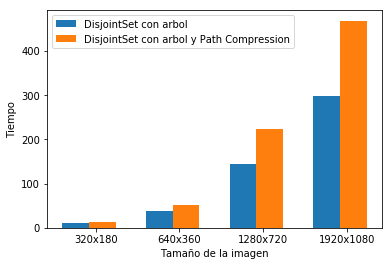

In [104]:
plt.clf()

metodos = [i for i in csv["Metodo"].unique() if i != "DisjointSet con Arreglo"]
tiempos = {}
for file in images.keys():
    data_x_file = csv[csv["Filename"] == file]

    mediciones = {}
    for metodo in metodos:
        mediciones[metodo] = np.median(data_x_file[data_x_file["Metodo"] == metodo]["Tiempo"])
    tiempos[file] = mediciones
    
    
tiempos_x_metodos = {}    

for metodo in metodos:
    tiempos_x_metodos[metodo] = []
    for f in tiempos.keys():
        tiempos_x_metodos[metodo].append(tiempos[f][metodo])

i = 0
for k, v in tiempos_x_metodos.items():
    print(k, v)
    plt.bar([100*j+32*i for j in range(1, len(images.keys())+1)], v, width=32, label=k)
    i += 1

plt.legend();
plt.xlabel("Tamaño de la imagen")
plt.ylabel("Tiempo");
plt.xticks([100*j+24 for j in range(1, len(images.keys())+1)], ["320x180", "640x360", "1280x720", "1920x1080"][:len(images.keys())])